In [2]:
#import libraries
import pandas as pd
from sklearn.metrics import *
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import warnings
import pickle
from sklearn.base import clone
from sklearn.compose import make_column_transformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_halving_search_cv  # noqa
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    cross_val_score, StratifiedKFold, 
    train_test_split, HalvingGridSearchCV
)
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier

In [47]:
pd.set_option('display.max_columns', None)
warnings.filterwarnings("ignore")

In [3]:
june_2021 = pd.read_csv('june-21.csv')
july_2021 = pd.read_csv('july-21.csv')

june_2022 = pd.read_csv('june-22.csv')
july_2022 = pd.read_csv('july-22.csv')     

In [5]:
june_2021.shape

(546124, 61)

In [7]:
#concatenate all dataframes
final_df = pd.concat([june_2021, july_2021, june_2022, july_2022], axis=0)
flights_df = final_df.copy()

In [8]:
flights_df = final_df.copy()

In [9]:
print("Data size: ", final_df.shape)

Data size:  (2301622, 61)


In [10]:
final_df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,AIR_TIME,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS
0,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,86.0,1.0,509.0,3,NaN,NaN,NaN,NaN,NaN,0.0
1,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,39.0,1.0,229.0,1,94.0,0.0,0.0,0.0,0.0,0.0
2,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,107.0,1.0,773.0,4,0.0,0.0,0.0,0.0,79.0,0.0
3,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,97.0,1.0,773.0,4,2.0,0.0,0.0,0.0,62.0,0.0
4,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,48.0,1.0,273.0,2,NaN,NaN,NaN,NaN,NaN,0.0


In [11]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2301622 entries, 0 to 594956
Data columns (total 61 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   YEAR                   int64  
 1   QUARTER                int64  
 2   MONTH                  int64  
 3   DAY_OF_MONTH           int64  
 4   DAY_OF_WEEK            int64  
 5   FL_DATE                object 
 6   OP_UNIQUE_CARRIER      object 
 7   OP_CARRIER_AIRLINE_ID  int64  
 8   OP_CARRIER             object 
 9   TAIL_NUM               object 
 10  OP_CARRIER_FL_NUM      int64  
 11  ORIGIN_AIRPORT_ID      int64  
 12  ORIGIN_AIRPORT_SEQ_ID  int64  
 13  ORIGIN_CITY_MARKET_ID  int64  
 14  ORIGIN                 object 
 15  ORIGIN_CITY_NAME       object 
 16  ORIGIN_STATE_ABR       object 
 17  ORIGIN_STATE_FIPS      int64  
 18  ORIGIN_STATE_NM        object 
 19  ORIGIN_WAC             int64  
 20  DEST_AIRPORT_ID        int64  
 21  DEST_AIRPORT_SEQ_ID    int64  
 22  DEST_CITY_MARKET_ID

In [12]:
#check number of missing values column wise
print(final_df.isna().sum())

YEAR                          0
QUARTER                       0
MONTH                         0
DAY_OF_MONTH                  0
DAY_OF_WEEK                   0
                         ...   
WEATHER_DELAY           1758215
NAS_DELAY               1758215
SECURITY_DELAY          1758215
LATE_AIRCRAFT_DELAY     1758215
DIV_AIRPORT_LANDINGS          1
Length: 61, dtype: int64


In [13]:

# 1.3 Categorise variables (reference: Flight delay prediction based on deep learning and Levenberg‐Marquart algorithm)

date_list = ['YEAR','MONTH','DAY_OF_MONTH','DAY_OF_WEEK', 'FL_DATE']
delay_time_list = ['DEP_TIME','DEP_DELAY','ArrTime','ARR_DELAY', 'DEP_DEL15']
delay_reason_list = ['CARRIER_DELAY','WEATHER_DELAY','NAS_DELAY','SECURITY_DELAY','LATE_AIRCRAFT_DELAY']
flight_info_list = ['OP_CARRIER_FL_NUM','ORIGIN','DEST']
     

In [14]:
print(final_df['OP_UNIQUE_CARRIER'].unique())

['9E' 'AA' 'AS' 'B6' 'DL' 'F9' 'G4' 'HA' 'MQ' 'NK' 'OH' 'OO' 'QX' 'UA'
 'WN' 'YV' 'YX']


In [15]:
carrier_names = {
    '9E': 'Endeavor Air',
    'AA': 'American Airlines',
    'AS': 'Alaska Airlines',
    'B6': 'JetBlue Airways',
    'DL': 'Delta Air Lines',
    'F9': 'Frontier Airlines',
    'G4': 'Allegiant Air',
    'HA': 'Hawaiian Airlines',
    'MQ': 'Envoy Air',
    'NK': 'Spirit Airlines',
    'OH': 'PSA Airlines',
    'OO': 'SkyWest Airlines',
    'QX': 'Horizon Air',
    'UA': 'United Airlines',
    'WN': 'Southwest Airlines',
    'YV': 'Mesa Airlines',
    'YX': 'Republic Airways'
}

In [16]:
final_df['Carrier_Name'] = final_df['OP_UNIQUE_CARRIER'].map(carrier_names)


In [17]:
final_df.head()

,YEAR,QUARTER,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,FL_DATE,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,...,FLIGHTS,DISTANCE,DISTANCE_GROUP,CARRIER_DELAY,WEATHER_DELAY,NAS_DELAY,SECURITY_DELAY,LATE_AIRCRAFT_DELAY,DIV_AIRPORT_LANDINGS,Carrier_Name
0,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,1.0,509.0,3,NaN,NaN,NaN,NaN,NaN,0.0,Endeavor Air
1,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,1.0,229.0,1,94.0,0.0,0.0,0.0,0.0,0.0,Endeavor Air
2,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,1.0,773.0,4,0.0,0.0,0.0,0.0,79.0,0.0,Endeavor Air
3,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,1.0,773.0,4,2.0,0.0,0.0,0.0,62.0,0.0,Endeavor Air
4,2021,2,6,1,2,6/1/2021 12:00:00 AM,9E,20363,9E,N131EV,...,1.0,273.0,2,NaN,NaN,NaN,NaN,NaN,0.0,Endeavor Air


In [18]:
carrier_df = final_df['OP_UNIQUE_CARRIER']

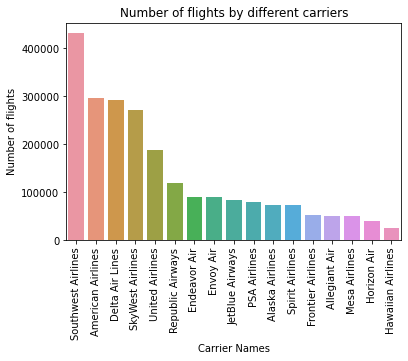

In [19]:
sns.countplot(x = final_df['Carrier_Name'], data = final_df, order= final_df['Carrier_Name'].value_counts().index)
plt.xticks(rotation = 90)
plt.xlabel('Carrier Names')
plt.ylabel('Number of flights')
plt.title('Number of flights by different carriers')
plt.show()

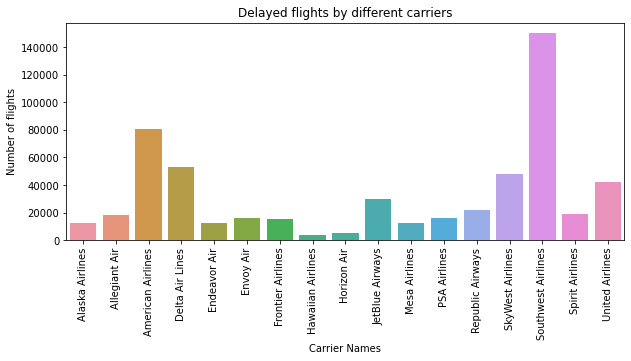

In [20]:
#number of departure delays vs Year
temp_df = final_df.copy(deep=True)
temp_df = temp_df[['DEP_DEL15','Carrier_Name']].groupby('Carrier_Name').sum('DEP_DEL15').reset_index()

fig = plt.figure(figsize=(10, 4))
sns.barplot(data=temp_df, x="Carrier_Name", y="DEP_DEL15")
plt.xticks(rotation = 90)
plt.xlabel('Carrier Names')
plt.ylabel('Number of flights')
plt.title('Delayed flights by different carriers')
plt.show()

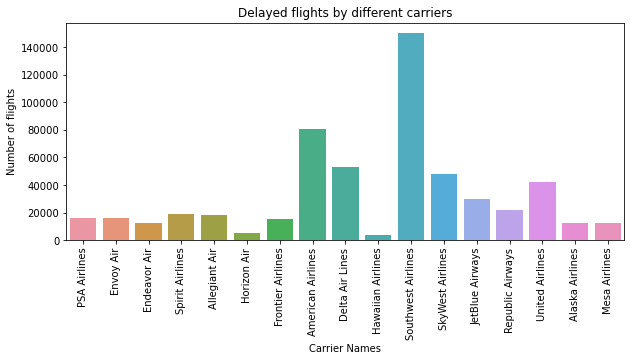

In [21]:
#number of departure delays vs Year
temp_df = final_df.copy(deep=True)
temp_df = temp_df[['DEP_DEL15','Carrier_Name']].groupby('Carrier_Name').sum('DEP_DEL15').reset_index()

fig = plt.figure(figsize=(10, 4))
sns.barplot(data=temp_df, x="Carrier_Name", y="DEP_DEL15", order= temp_df['Carrier_Name'].value_counts().index)
plt.xticks(rotation = 90)
plt.xlabel('Carrier Names')
plt.ylabel('Number of flights')
plt.title('Delayed flights by different carriers')
plt.show()

In [22]:
carrier_stats = final_df.groupby(['Carrier_Name']).agg({
    'FLIGHTS': 'count',
    'DEP_DEL15': 'sum'
})

In [23]:
carrier_stats

,FLIGHTS,DEP_DEL15
Carrier_Name,,
Alaska Airlines,73645,12348.0
Allegiant Air,50641,18143.0
American Airlines,294984,80636.0
Delta Air Lines,291538,52805.0
Endeavor Air,90311,12162.0
Envoy Air,89921,16071.0
Frontier Airlines,51662,15343.0
Hawaiian Airlines,25234,4015.0
Horizon Air,39299,5288.0


In [24]:
# calculate the percentage of delayed flights for each carrier
carrier_stats['DELAY_PERCENTAGE'] = carrier_stats['DEP_DEL15'] / carrier_stats['FLIGHTS'] * 100

In [25]:
# reset the index to make 'OP_UNIQUE_CARRIER' a regular column
carrier_stats = carrier_stats.reset_index()

In [26]:
# sort the carriers by the number of flights
carrier_stats = carrier_stats.sort_values(by=['FLIGHTS'], ascending=False)


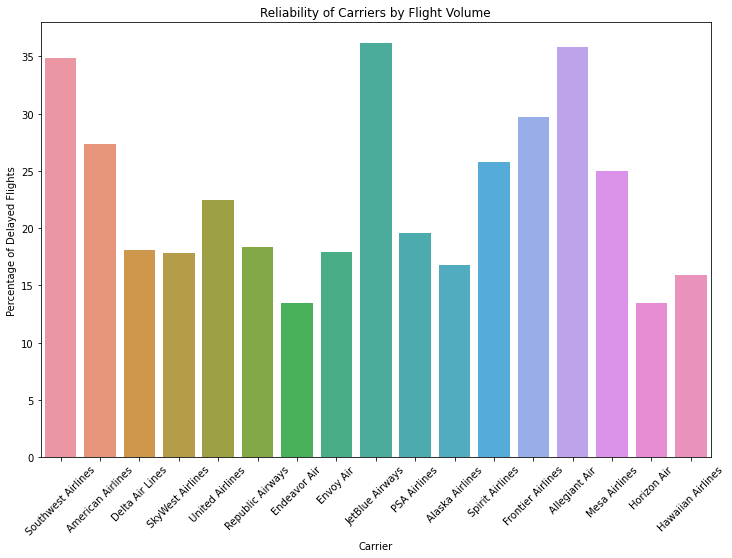

In [30]:
# plot the results
plt.figure(figsize=(12, 8))
sns.barplot(x='Carrier_Name', y='DELAY_PERCENTAGE', data=carrier_stats)
plt.xticks(rotation = 45)
plt.xlabel('Carrier')
plt.ylabel('Percentage of Delayed Flights')
plt.title('Reliability of Carriers by Flight Volume')
plt.show()

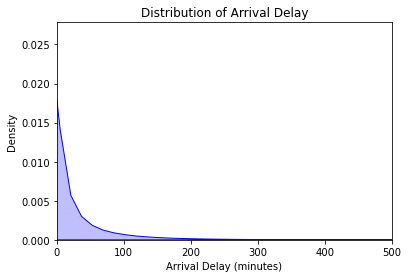

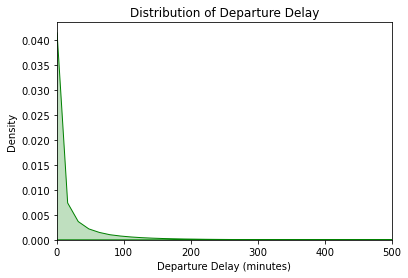

In [28]:
sns.kdeplot(data=final_df, x='ARR_DELAY', color='blue', fill=True)
plt.xlim(0,500)
plt.xlabel('Arrival Delay (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Arrival Delay')
plt.show()

# Plot the distribution of departure delay
sns.kdeplot(data=final_df, x='DEP_DELAY', color='green', fill=True)
plt.xlim(0,500)
plt.xlabel('Departure Delay (minutes)')
plt.ylabel('Density')
plt.title('Distribution of Departure Delay')
plt.show()

In [78]:
delay_reasons = final_df[['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY']]
delay_reasons = pd.melt(delay_reasons, var_name='Delay Reason')


In [80]:
delay_reasons

,Delay Reason,value
0,CARRIER_DELAY,NaN
1,CARRIER_DELAY,94.0
2,CARRIER_DELAY,0.0
3,CARRIER_DELAY,2.0
4,CARRIER_DELAY,NaN
...,...,...
11508105,LATE_AIRCRAFT_DELAY,NaN
11508106,LATE_AIRCRAFT_DELAY,NaN
11508107,LATE_AIRCRAFT_DELAY,NaN
11508108,LATE_AIRCRAFT_DELAY,NaN


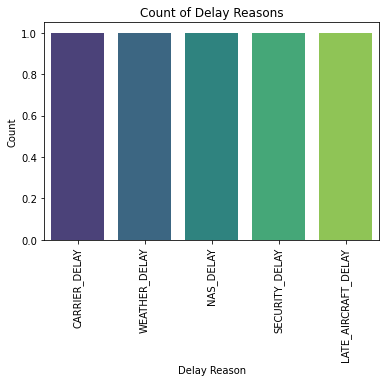

In [89]:
# Create a new dataframe with a single column containing all delay reasons
delay_reasons2 = pd.DataFrame({
    'Delay Reason': ['CARRIER_DELAY', 'WEATHER_DELAY', 'NAS_DELAY', 'SECURITY_DELAY', 'LATE_AIRCRAFT_DELAY'],
    'Count': [
        final_df['CARRIER_DELAY'].notnull().sum(),
        final_df['WEATHER_DELAY'].notnull().sum(),
        final_df['NAS_DELAY'].notnull().sum(),
        final_df['SECURITY_DELAY'].notnull().sum(),
        final_df['LATE_AIRCRAFT_DELAY'].notnull().sum()
    ]
})

# Plot the count using sns.countplot
sns.countplot(data=delay_reasons2, x='Delay Reason', palette='viridis')

# Set the plot title and axes labels
plt.xticks(rotation = 90)
plt.title('Count of Delay Reasons')
plt.xlabel('Delay Reason')
plt.ylabel('Count')

# Show the plot
plt.show()


In [90]:
delay_reasons2

,Delay Reason,Count
0,CARRIER_DELAY,543407
1,WEATHER_DELAY,543407
2,NAS_DELAY,543407
3,SECURITY_DELAY,543407
4,LATE_AIRCRAFT_DELAY,543407
